# Physics 911 Term Project
### Mingyoung Jeng

Adapting aspects of Efficiently Updatable Neural Networks (NNUE) into quantum machine learning circuits.

### Efficiently Updatable Neural Networks (NNUE)

NNUEs are a type of neural network that has shown great advantage in engines designed to play shogi and chess, where they are used for positional evaluation. Compared to deep neural-networks like those used in DeepMind's Alpha- series of engines (e.g. AlphaZero in chess), they can be efficiently run on CPUs duea structure prioritizing efficiency.

![](https://github.com/glinscott/nnue-pytorch/raw/master/docs/img/A-768-8-8-1.svg) 

[Source](https://github.com/glinscott/nnue-pytorch/blob/master/docs/nnue.md)

First, the networks are shallow, but fully interconnected between nodes, resulting in a relatively small network. Second, they are sparse, meaning they expect the majority of inputs to be $0$, which enables efficient lazy updates between iterations.

Given the state of current quantum machines, the same motivations behind NNUEs could also hold for QPUs, especially the desire for shallower, less costly networks.

Sources: [Original Paper (JPN)](https://github.com/ynasu87/nnue/blob/master/docs/nnue.pdf), [Original Paper (Unofficial English translation)](https://github.com/asdfjkl/nnue/blob/main/nnue_en.pdf), [GitHub](https://github.com/glinscott/nnue-pytorch/blob/master/docs/nnue.md), [saumikn](https://saumikn.com/blog/a-brief-guide-to-stockfish-nnue/), [Chess.com](https://www.chess.com/blog/the_real_greco/evolution-of-a-chess-fish-what-is-nnue-anyway)

### Quantum Variational Algorithms

As a near-term classification algorithm, this algorithm formed the foundation upon which I implemented my NNUE-inspired circuit design. 

![](https://learn.qiskit.org/content/quantum-machine-learning/images/vqc/vqc.svg)

The general concept depends on two parameterized circuits which have a fixed structure whose gates (rotation gates, specifically) can be updated between executions to different values. The first circuit, $\phi$ is a data encoding circuit, which parses the given inputs, and the second, $W(\overrightarrow{\theta})$, a variational circuit which returns a series of labels (measurements). These outputs are handled classicially by passing them into a cost function which is used by a gradient-descent optimizer to decide on the next iteration's set of parameters.

Source: [Qiskit](https://learn.qiskit.org/course/machine-learning/variational-classification)

### Project Objective

Determine a parameterized quantum circuit that reflects the principal benefits of NNUEs.
* Efficient updating
* Sparse
* Shallow
* Fully interconnected

The closest analog in the quantum space that fulfills the same role of efficient iteration in NNUEs is circuit parameterization. While all quantum circuit need repeated measurement to achieve accurate results, circuit parameterization does allow the structure of a circuit to remain constant over all executions, with only the parameters needing to be updated.

I have chosen to interpret "sparseness" to mean that if any qubit is found to be in its ground state, it shouldn't have any effect on the final result.

Circuit depth is already a primary constraint in contemporary quantum algorithm design due to decoherence. Here, I specifically tried to target a $O(n)$ depth, where $n$ is the number of qubits.

Fully interconnected is already a natural concept in the quantum domain, due to superposition and entanglement. In practice, I looked for a circuit that ensured each qubit could have an effect on the final measurement.

### Adapting a typical variational circuit algorithm

As a control, we have the `qiskit` tutorial code for a variational classifier adapted to provide "evaluation" between $0.0-1.0$, as seen in classical NNUEs.

In [1]:
from qiskit import Aer
from qiskit.utils import algorithm_globals
from qiskit_ibm_runtime import QiskitRuntimeService
algorithm_globals.random_seed = 42069

import numpy as np
np.random.seed(algorithm_globals.random_seed)

num_qubits = 7
num_training = 40
num_test = 20

local = True

**Select a backend**

The `local` flag above can be used to toggle between one's local `Aer` simulator or use a quantum computer via the Qiskit runtime service that is recommended for running this type of application on real quantum hardware. However, I've found the service to be intermittent.

In [2]:
if local:
    backend = Aer.get_backend('aer_simulator')
else:
    service = QiskitRuntimeService(
        channel='ibm_quantum',
        instance='ibm-q-research-2/uni-kansas-1/main',
    )
    # backend = service.get_backend('ibmq_qasm_simulator')
    backend = service.least_busy(simulator=False, operational=True, min_num_qubits=num_qubits)

The "evaluation" function can be anything in general. However, In this case, I chose an evaluation function that outputs entropy using a statevector in lieu of a conventional probability distribution.

In [3]:
def eval(psi: np.ndarray) -> float:
    """
    This function gives the "correct" output for any input data
    Args:
        psi (list): Input statevector
    Returns:
        float: Value between 0.0 and 1.0
    """
    
    psi = psi / np.linalg.norm(psi)
    
    # output = 0
    # for i in psi[int(len(psi)/2):]:
    #     output += i**2
    # return np.sqrt(output)
    
    return -sum(psi * np.log2(psi + 1e-10)) / len(psi)

Prepare training and testing data

In [4]:
def random_data(qubits: int):
    """
    Generates random sparse datasets
    Args:
        qubits (int): number of qubits in statevector
    Returns:
        np.ndarray: statevector
    """
    psi = np.zeros(2**qubits)
    n = np.random.randint(1, 2**(qubits-1))
    psi[:n] = np.random.rand(n)
    np.random.shuffle(psi)
    psi = psi / np.linalg.norm(psi)
    return psi

train_data = [random_data(num_qubits) for _ in range(num_training)]
train_labels = [eval(x) for x in train_data]

test_data = [random_data(num_qubits) for _ in range(num_test)]
test_labels = [eval(x) for x in test_data]

This circuit is the template upon which $\theta$ parameters are bound. Specifically, it is the circuit used in the [`qiskit` variational circuits tutorial](https://learn.qiskit.org/course/machine-learning/variational-classification#variational-3-0), called [`TwoLocal`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html). This is what I will be comparing my circuit design against.

The tutorial used a [`ZZFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html) for the data encoding circuit, but those could only go up to 3 qubits, so I opted to use the general `initialize` function instead.

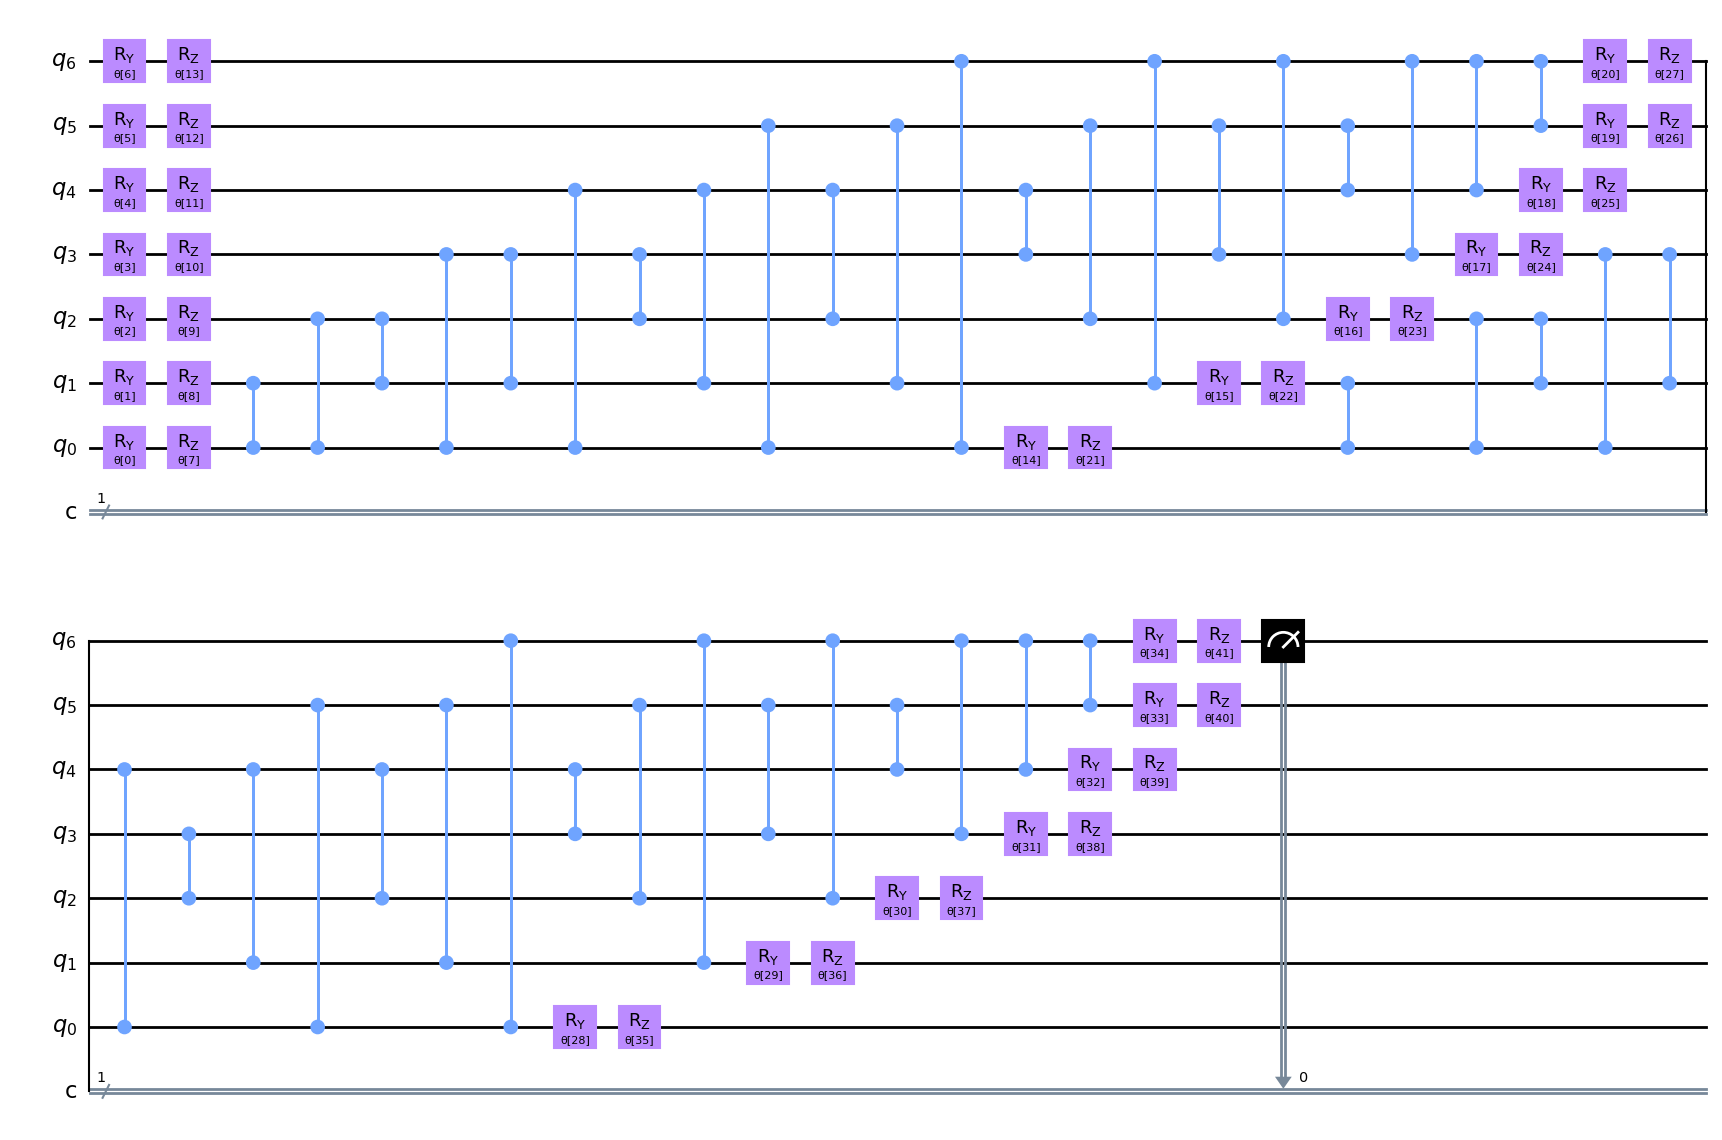

In [5]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal

QML = QuantumCircuit(num_qubits, 1)

var = TwoLocal(num_qubits, ['ry', 'rz'], 'cz', reps=2)
QML.compose(var, inplace=True)
        
QML.measure(num_qubits-1, 0)

num_variational = len(var.ordered_parameters)
        
QML.decompose().draw('mpl', reverse_bits=True)

This function was lifted and modified from the aforementioned `qiskit` tutorial. It adds in the `initialize` data encoding portion, binds the passed parameters, and returns the final quantum circuit.

In [6]:
# from qiskit.circuit.library import EfficientSU2

def circuit_instance(data, variational):
    qc = QuantumCircuit(num_qubits)
    qc.initialize(data)
    # qc = EfficientSU2(num_qubits=num_qubits, reps=1)
    # qc.assign_parameters(data, inplace=True)
    qc.compose(QML.assign_parameters(variational), inplace=True)
    
    return qc

The general structure of these methods was taken from the `qiskit` tutorial. `label_probability` takes in the measurement counts of a circuit execution and returns the probabilities. `evaluation_probability` takes in parameters to generate circuits, executes them, and uses `label_probability` to return the probabilities. Finally, the `cost_function` is calculated from the `label_probability`. In a general ML context, the cost function is the metric to minimize (smaller $\rightarrow$ more correct)

I modified the `label_probability` and `cost_function` methods to suit my modified problem set (evaluation vs classification). I also added `QiskitRuntime` compatibility to the `evaluation_probability` function via the [`Sampler`](https://qiskit.org/documentation/stubs/qiskit.primitives.Sampler.html) primitive.

In [7]:
from qiskit import execute
from qiskit_ibm_runtime import Session, Sampler
sampler = None # Save for later

def label_probability(counts):
    if "0" not in counts.keys():
        return 0
    return np.sqrt(counts["0"] / sum(counts.values()))

def evaluation_probability(data, variational):
    """Classify data points using given parameters.
    Args:
        data (list): Set of data points to classify
        variational (list): Parameters for `VAR_FORM`
    Returns:
        list[dict]: Probability of circuit classifying
                    each data point as 0 or 1.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    results = execute(circuits, backend).result() if local else sampler.run(circuits).result()
    evals = [label_probability(results.get_counts(c)) for c in circuits]
    
    return evals

def cost_function(data, labels, variational):
    classifications = evaluation_probability(data, variational)
    cost = sum([np.abs(classification - label) for classification, label in zip(classifications, labels)])
    return cost

The following is simply the tutorial's optimizer refactored to be compatible with `QiskitRuntime`. Specifically, a [`SPSA`](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SPSA.html) class performs gradient descent on the value returned by `cost_function` to determine the next iteration of $\theta$ patameters to bind to the variational circuit.

The cost of each iteration is stored and plotted below.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Executed in 662.8437982500182 seconds.


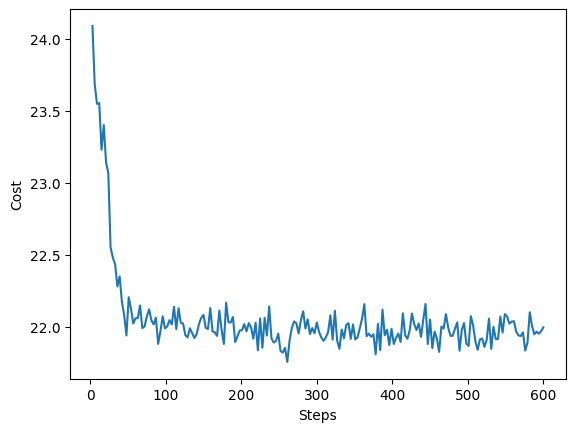

In [8]:
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)
        
def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(train_data, train_labels, variational)

# Set up the optimization
from qiskit.algorithms.optimizers import SPSA
import matplotlib.pyplot as plt
from time import perf_counter
%matplotlib inline


def run_qml():
    start = perf_counter()
    log = OptimizerLog()
    optimizer = SPSA(maxiter=200, callback=log.update)

    # Run the optimization
    initial_point = np.random.rand(num_variational)
    result = optimizer.minimize(objective_function, initial_point)
    t_exec = perf_counter() - start
    print(f"Executed in {t_exec} seconds.")

    opt_var = result.x
    opt_value = result.fun

    fig = plt.figure()
    plt.plot(log.evaluations, log.costs)
    plt.xlabel('Steps')
    plt.ylabel('Cost')
    plt.show()
    
    return opt_var, opt_value

if local:
    opt_var, opt_value = run_qml()
else:
    with Session(service=service, backend=backend):
        sampler = Sampler()
        opt_var, opt_value = run_qml()

Now that the circuit is trained, we can try plugging in our test dataset (instead of the training dataset) to see how it performs.

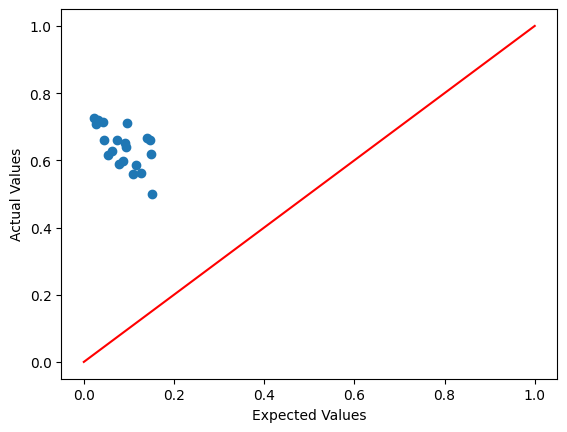

In [9]:
labels = evaluation_probability(test_data, opt_var)

fig = plt.figure()
plt.scatter(test_labels, labels)

x = np.linspace(0,1,100)
plt.plot(x, x, '-r', label='ideal')

plt.xlabel('Expected Values')
plt.ylabel('Actual Values')
plt.show()

### Repeat the process with custom classification circuit

Below is the NNUE-inspired circuit design, motivated solely by the previously-discussed constraints. The circuit is very shallow, owing to the lack of phase gates, which doesn't affect the final probability measurements, and that only 1 qubit is measured. Evaluation only needs to return a value between 0 and 1, so only 1 qubit is required for that. Thus, all other qubits besides the target need only be used to control that target, adhering to the contraint that qubits in their ground state much serve as $I$ gates.

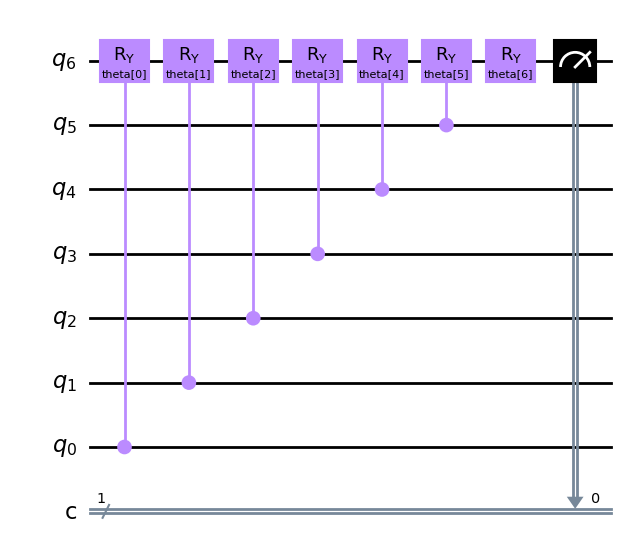

In [10]:
from qiskit.circuit import Parameter

QML = QuantumCircuit(num_qubits, 1)
target = num_qubits - 1

for i in range(num_qubits):
    theta = Parameter(f'theta[{i}]')
    
    if i == target:
        QML.ry(theta, target)
    else:
        QML.cry(theta, i, target)
        
QML.measure(target, 0)

num_variational = num_qubits
        
QML.draw('mpl', reverse_bits=True)

Proceed to run this circuit through the same process as the control.

Executed in 245.93981787501252 seconds.


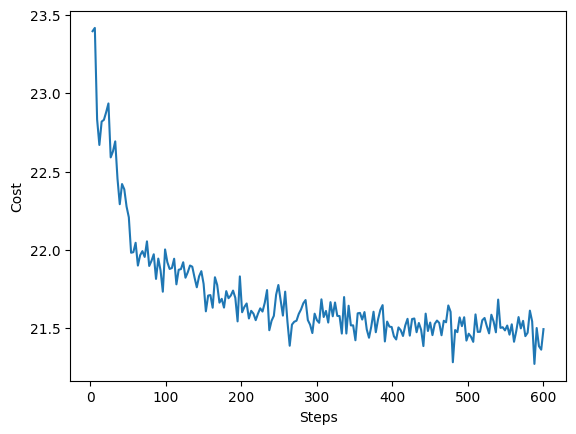

In [11]:
if local:
    opt_var, opt_value = run_qml()
else:
    with Session(service=service, backend=backend):
        sampler = Sampler()
        opt_var, opt_value = run_qml()

Once again, we can also plug in the test dataset.

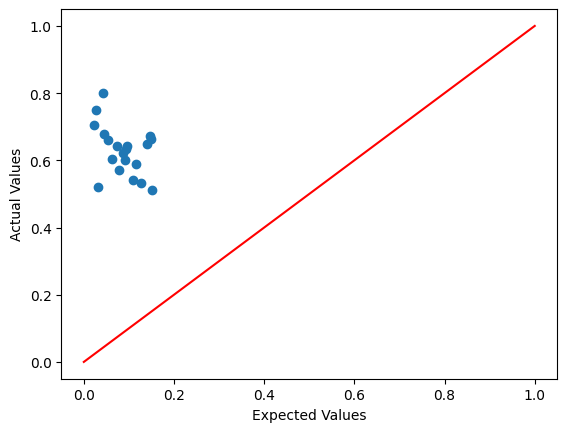

In [12]:
labels = evaluation_probability(test_data, opt_var)

fig = plt.figure()
plt.scatter(test_labels, labels)

x = np.linspace(0,1,100)
plt.plot(x, x, '-r', label='ideal')

plt.xlabel('Expected Values')
plt.ylabel('Actual Values')
plt.show()

### Conclusion

For this particular `eval` function, we see that it managed to converge to 0 faster both in number of iterations and in actual time taken, highlighting the advantages of a shallower circuit with fewer parameters. However, this comes at the cost of flexibility for different evaluation functions, i.e. because the simpler structure, this circuit may not be compatible with all target functions.

Even classically, NNUEs sacrifice some accuracy ceiling in exchange for speed of execution, which is useful for a game engine running under time constraints. This can also be applied in quantum, where shallower circuits that minimize execution time is also critical.

Nevertheless, this project did demonstrate a viable scenario that reflects the potential benefits of the NNUE principles in a QML context. Moreover, it also highlights how there exist many viable structures for a given problem, just like in classical machine learning.